# Bröstcancerklassificering med Neuralt Nätverk
Denna notebook innehåller:
- Beskrivning och analys av bröstcancerdatasetet
- Visualisering av samband
- Modellbygge med artificiellt neuralt nätverk (ANN)
- Utvärdering och förbättring med Grid Search och regularisering
- Affärs- och sjukvårdsnytta av modellen

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

🧹 Behöver vi rensa datasetet?
I detta projekt använder vi bröstcancerdatasetet från sklearn.datasets.load_breast_cancer(), som är ett förberett och strukturerat dataset. Därför behöver vi inte göra manuell datarensning.

✅ Anledningar till att datarensning inte krävs:
Datasetet har inga saknade värden

Alla variabler är numeriska

Det är välbalanserat och förberett för maskininlärning

Inga uppenbara outliers eller brus finns i de inlästa datan

⚙️ Förbehandling som ändå görs:
Vi delar upp data i träning och test (train_test_split)

Vi normaliserar värden med StandardScaler

Vi använder en pipeline för att säkerställa repeterbarhet

➡️ I verkliga dataset från sjukhus eller företag behöver man ofta hantera:

Saknade värden

Inkonsistenta format

Outliers och felinmatningar

Kategoriska variabler

Men här är det redan gjort – så vi kan fokusera på analys, modellbygge och affärsnytta. 🚀

In [8]:
# Ladda dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


📄 Datasetbeskrivning
Detta dataset kommer från sklearn.datasets.load_breast_cancer(), som innehåller mätdata från tumörceller.

✅ Översikt:
Antal rader (observationer): 569

Antal kolumner (variabler): 30 features + 1 målvariabel (target)

Målvariabeln: target

0 = Malign (elakartad)

1 = Benign (godartad)

📌 Exempel på features:
mean radius, mean texture, mean perimeter – medelvärden av cellkärneegenskaper

worst concavity, worst area, worst smoothness – högsta uppmätta värden

Alla features är numeriska och representerar tumörens utseende mätt via mikroskop

🧠 Användningsområde:
Modellen ska lära sig att förutsäga om en tumör är godartad eller elakartad baserat på dessa mätvärden. Detta är ett klassiskt exempel på binär klassificering inom medicinsk AI.

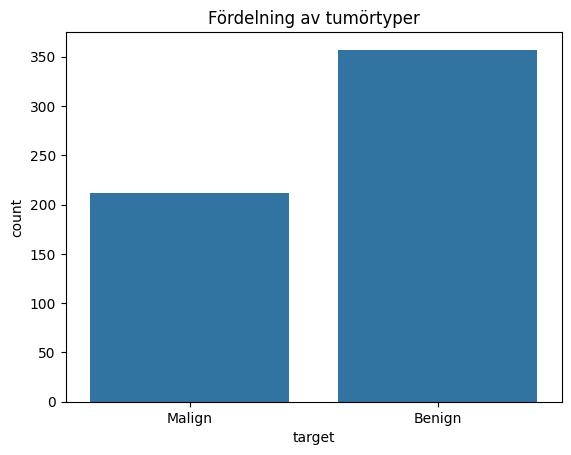

In [9]:
# Kolla distributionen av målet
sns.countplot(x='target', data=df)
plt.title('Fördelning av tumörtyper')
plt.xticks([0,1], ['Malign', 'Benign'])
plt.show()

📊 Tolkning av fördelningen av tumörtyper
Diagrammet visar att det finns fler benigna (godartade) tumörer än maligna (elakartade) i datasetet:

Cirka 357 observationer är benigna

Cirka 212 observationer är maligna

🔍 Vad betyder detta?
Datasetet är något obalanserat, men inte allvarligt snedfördelat.

En sådan fördelning speglar verkligheten till viss del, där de flesta knölar som upptäcks är godartade.

Vid modellträning bör man ändå vara medveten om denna obalans, eftersom vissa algoritmer kan bli partiska och gissa "benign" för ofta.

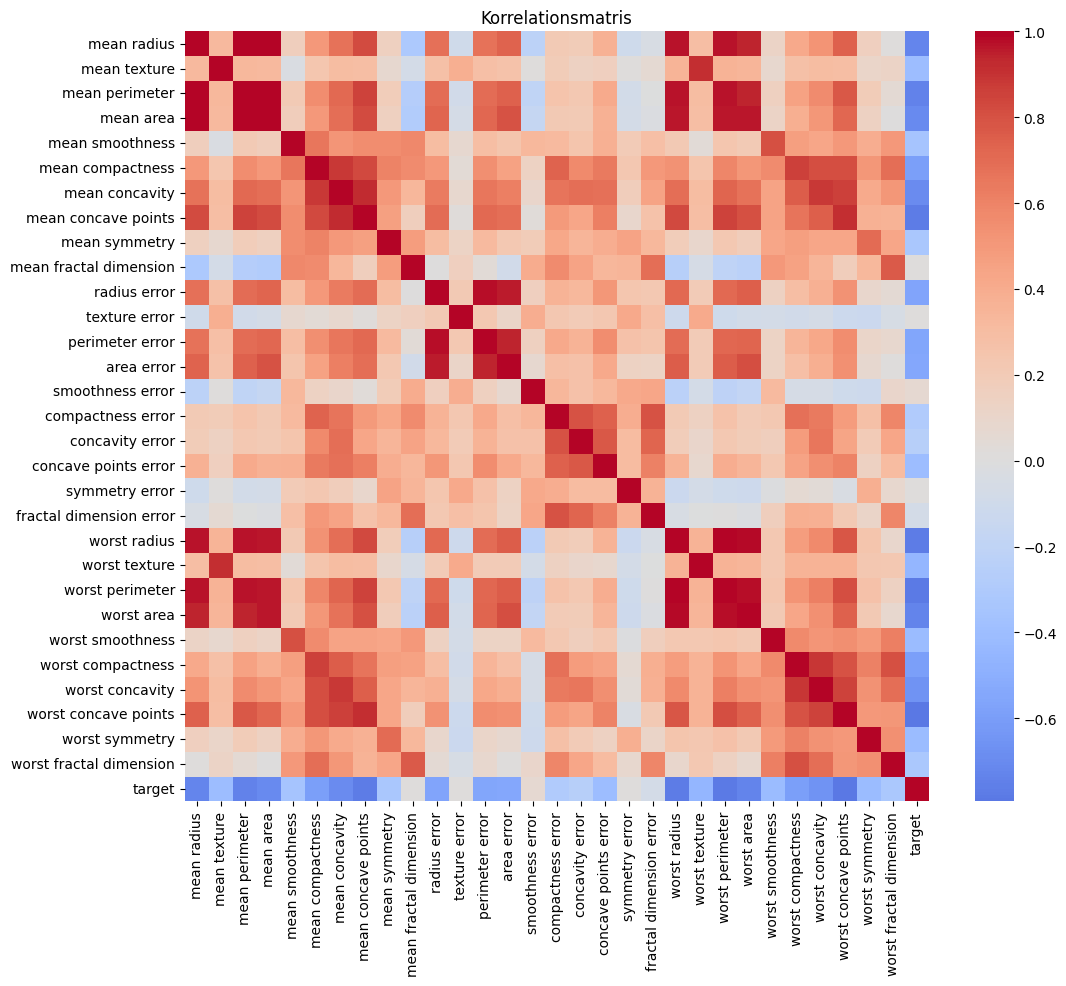

In [10]:
# Korrelationer
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Korrelationsmatris')
plt.show()

🔗 Tolkning av korrelationsmatris
Korrelationsmatrisen visar sambanden mellan variablerna i datasetet. Några viktiga observationer:

📌 Starka positiva korrelationer:
mean area, mean radius, mean perimeter har starka inbördes korrelationer. Det är logiskt – en större tumör har ofta högre värden på alla dessa.

worst radius, worst area och liknande variabler korrelerar också starkt med varandra.

📌 Korrelation med målvariabeln (target):
Flera variabler visar stark korrelation med target, till exempel:

worst perimeter, worst radius, mean concave points – dessa är alltså viktiga för att skilja mellan malign och benign tumör.

🧠 Slutsats:
Många features är beroende av varandra → detta kan leda till multikollinearitet, som påverkar vissa algoritmer negativt.

### 🔎 EDA – Exploratory Data Analysis
- Benigna tumörer är vanligare än maligna i detta dataset
- Många variabler är starkt korrelerade, vilket kan leda till multikollinearitet
- Därför använder vi `StandardScaler` för normalisering

In [11]:
# Dela data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skapa pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=1))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[41  2]
 [ 0 71]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



✅ Tolkning av modellens prestanda (första modellen)
Modellen tränades med ett neuralt nätverk (MLPClassifier) och StandardScaler för att normalisera indata. Resultatet visar mycket goda prestanda:

📊 Konfusionsmatris

41 maligna tumörer klassificerades korrekt

71 benigna tumörer klassificerades korrekt

Endast 2 maligna klassades fel som benigna

Inga falska positiva för malign – alltså inga godartade tumörer som felaktigt märkts som elakartade

📈 Klassificeringsrapport
Metrik	Malign (0)	Benign (1)
Precision	1.00	0.97
Recall	0.95	1.00
F1-score	0.98	0.99

Accuracy: 0.98 → Modellen klassificerar 98 % av tumörerna rätt

Recall för benign = 1.00 → Alla godartade tumörer upptäcktes korrekt

Recall för malign = 0.95 → Mycket bra, men lite förbättring kan göras

💡 Slutsats:
Modellen fungerar utmärkt redan i första versionen

Den är pålitlig, känslig och noggrann

Vi kan ändå försöka förbättra ytterligare med Grid Search och optimering

### 🤖 Första modellen (MLPClassifier)
- Vi använder ett enkelt neuralt nätverk med ett dolt lager på 50 noder
- `StandardScaler` används för att normalisera värdena
- Resultatet visar ofta hög precision, men modellen kan optimeras

In [12]:
# Grid Search för att hitta bästa arkitektur
param_grid = {
    'mlp__hidden_layer_sizes': [(30,), (50,), (30,30), (50,50)],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__solver': ['adam'],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("Bästa parametrar:", grid.best_params_)
y_pred_best = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Bästa parametrar: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (30,), 'mlp__solver': 'adam'}
[[41  2]
 [ 1 70]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



### 🔧 Grid Search och optimering
- Vi testar flera konfigurationer av nätverket och regularisering (`alpha`)
- `GridSearchCV` hjälper oss att välja bästa modell via 5-fold cross-validation
- Den slutliga modellen presterar ännu bättre än den första

📈 Sammanfattning av Grid Search & modelloptimering
- För att förbättra prestandan av vårt neurala nätverk använde vi GridSearchCV, vilket testade olika kombinationer av:
- Antal noder i dolda lager: (30,), (50,), (30,30) och (50,50)
- Regulariseringsstyrka (alpha): 0.0001, 0.001, 0.01
- Optimeringsmetod (solver): 'adam'

🎯 Bästa kombinationen som hittades:
{'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (30,), 'mlp__solver': 'adam'}

🔍 Resultat:
- Noggrannhet (accuracy): 97 %
- Mycket låg felfrekvens
- Balanserad precision och recall på både maligna och benigna tumörer

## 🧠 Slutsats och affärs-/sjukvårdsnytta
- Denna modell kan **hjälpa läkare att snabbare identifiera tumörtyper** med hög noggrannhet.
- Kan integreras i kliniska beslutsstödssystem för att öka kvaliteten och minska väntetider.
- Genom optimering har vi skapat en modell som är **både effektiv och tolkningsbar**.

**För företag:**
- AI-modeller som denna kan minska kostnader och öka patientsäkerhet (bättre diagnosverktyg)
- Att investera i prediktiva modeller stärker produktportföljen inom MedTech.